# Spectrally-Annotated Graph Benchmarks Demo

This notebook demonstrates the **Spectrally-Annotated Graph Benchmarks** dataset, which provides
graphs annotated with spectral properties for studying graph distinguishability.

**What this dataset contains:**
- Synthetic graph pairs in three categories: **exactly cospectral**, **near-cospectral**, and **control** pairs
- Each graph is annotated with: eigenvalues, delta_min (minimum spectral gap), SRI (Spectral Resolution Index) at K=2/4/8/16/20, Vandermonde condition numbers, RWSE (Random Walk Structural Encoding) for walk lengths 1-20, and top-10 local spectral measures per node

**What this notebook demonstrates:**
1. Loading and parsing the spectrally-annotated graph data
2. Core spectral annotation functions (eigendecomposition, SRI, RWSE)
3. Re-computing spectral annotations on loaded graphs to verify correctness
4. Visualizing spectral properties across cospectral/near-cospectral/control categories

In [1]:
# --- Install dependencies ---
import sys

_colab = "google.colab" in sys.modules

if not _colab:
    # Outside Colab: install everything unconditionally
    %pip install -q numpy matplotlib

if _colab:
    # Inside Colab: pin to Colab-compatible versions
    %pip install -q numpy==1.26.4 matplotlib==3.7.1


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Imports ---
import json
import math
import os
import warnings
from typing import Any

import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Loading

Load the spectrally-annotated graph data from GitHub (or local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-ace67e-the-walk-resolution-limit-a-super-resolu/main/dataset_iter1_spectrally_anno/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception:
        pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f:
            return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data["datasets"]:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 1 dataset(s)
  Synthetic-aliased-pairs: 30 examples


## Configuration

Tunable parameters controlling the spectral annotation computation.

In [5]:
# --- Config: tunable parameters ---
# SRI is computed for these K values
K_VALUES = [2, 4, 8, 16, 20]            # Original: [2, 4, 8, 16, 20]

# Random walk structural encoding walk lengths
RWSE_WALK_LENGTHS = list(range(1, 21))   # Original: list(range(1, 21))

# Number of top local spectral components to keep per node
TOP_N_SPECTRAL = 10                       # Original: 10

# Decimal places for rounding
FLOAT_DP_EIGENVAL = 8                     # Original: 8
FLOAT_DP_OTHER = 6                        # Original: 6

# How many examples to process for the verification step
N_EXAMPLES_TO_VERIFY = 30                 # All examples (original: 30)

## Parse and Explore the Data

Each example stores its graph structure and spectral annotations as a JSON string in the `input` field. Let's parse them and inspect the structure.

In [6]:
# Parse all examples from the Synthetic-aliased-pairs dataset
examples = data["datasets"][0]["examples"]
parsed = []
for ex in examples:
    graph = json.loads(ex["input"])
    graph["metadata"] = {k: v for k, v in ex.items() if k.startswith("metadata_")}
    parsed.append(graph)

print(f"Total examples: {len(parsed)}")
print(f"\nCategories:")
cats = {}
for g in parsed:
    cat = g["metadata"].get("metadata_pair_category", "unknown")
    cats[cat] = cats.get(cat, 0) + 1
for cat, count in sorted(cats.items()):
    print(f"  {cat}: {count} graphs")

# Show one example
print(f"\nExample graph: {parsed[0].get('graph_name', 'N/A')}")
print(f"  Nodes: {parsed[0]['num_nodes']}")
print(f"  Edges: {len(parsed[0]['edge_index'][0])}")
print(f"  Eigenvalues: {parsed[0]['spectral']['eigenvalues']}")
print(f"  delta_min: {parsed[0]['spectral']['delta_min']}")
print(f"  SRI: {parsed[0]['spectral']['sri']}")
print(f"  Vandermonde cond: {parsed[0]['spectral']['vandermonde_cond']}")

Total examples: 30

Categories:
  control: 8 graphs
  exactly_cospectral: 12 graphs
  near_cospectral: 10 graphs

Example graph: K_1_4
  Nodes: 5
  Edges: 8
  Eigenvalues: [-2.0, 0.0, 0.0, 0.0, 2.0]
  delta_min: 2.0
  SRI: {'K=2': 4.0, 'K=4': 8.0, 'K=8': 16.0, 'K=16': 32.0, 'K=20': 40.0}
  Vandermonde cond: {'K=2': 2.0, 'K=4': 1000000000000000.0, 'K=8': 1000000000000000.0, 'K=16': 1000000000000000.0, 'K=20': 1000000000000000.0}


## Core Spectral Annotation Functions

These functions are the heart of the dataset builder: they convert a graph's adjacency matrix into spectral annotations (eigenvalues, delta_min, SRI, Vandermonde condition numbers, RWSE, and local spectral measures).

In [7]:
def edge_index_to_adj(edge_index: list[list[int]], num_nodes: int) -> np.ndarray:
    """Convert COO edge_index [[src,...],[dst,...]] to dense adjacency matrix."""
    A = np.zeros((num_nodes, num_nodes), dtype=np.float64)
    srcs, dsts = edge_index[0], edge_index[1]
    for s, d in zip(srcs, dsts):
        if 0 <= s < num_nodes and 0 <= d < num_nodes:
            A[s, d] = 1.0
    # Ensure symmetry for undirected graphs
    A = np.maximum(A, A.T)
    return A


def compute_spectral_annotations(
    A: np.ndarray,
    k_values: list[int] = None,
    rwse_lengths: list[int] = None,
    top_n: int = None,
) -> dict[str, Any]:
    """
    Compute full spectral annotations for an adjacency matrix A.
    Returns dict with eigenvalues, delta_min, SRI, vandermonde_cond, rwse, local_spectral.
    """
    if k_values is None:
        k_values = K_VALUES
    if rwse_lengths is None:
        rwse_lengths = RWSE_WALK_LENGTHS
    if top_n is None:
        top_n = TOP_N_SPECTRAL

    n = A.shape[0]
    if n == 0:
        return {
            "eigenvalues": [], "delta_min": 0.0,
            "sri": {f"K={k}": 0.0 for k in k_values},
            "vandermonde_cond": {f"K={k}": 1e15 for k in k_values},
            "rwse": [], "local_spectral": [],
        }

    # -- Eigendecomposition --
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    eigenvalues = np.sort(eigenvalues)  # ascending
    eigenvalues_list = [round(float(e), FLOAT_DP_EIGENVAL) for e in eigenvalues]

    # -- delta_min: minimum nonzero gap between consecutive eigenvalues --
    gaps = np.diff(eigenvalues)
    nonzero_gaps = gaps[gaps > 1e-10]
    delta_min = float(np.min(nonzero_gaps)) if len(nonzero_gaps) > 0 else 0.0
    delta_min = round(delta_min, FLOAT_DP_OTHER)

    # -- SRI(G, K) = delta_min * K --
    sri = {f"K={k}": round(delta_min * k, FLOAT_DP_OTHER) for k in k_values}

    # -- Vandermonde condition numbers --
    vandermonde_cond = {}
    for k in k_values:
        k_use = min(k, n)
        try:
            V = np.zeros((k_use, n), dtype=np.float64)
            for ki in range(k_use):
                V[ki, :] = eigenvalues ** (ki + 1)
            cond = float(np.linalg.cond(V))
            if not np.isfinite(cond):
                cond = 1e15
            vandermonde_cond[f"K={k}"] = round(min(cond, 1e15), FLOAT_DP_OTHER)
        except (np.linalg.LinAlgError, ValueError):
            vandermonde_cond[f"K={k}"] = 1e15

    # -- RWSE: diagonal of (D^{-1}A)^k for random walk return probs --
    degree = A.sum(axis=1)
    D_inv = np.zeros_like(degree)
    nonzero_deg = degree > 0
    D_inv[nonzero_deg] = 1.0 / degree[nonzero_deg]
    T = D_inv[:, None] * A  # Transition matrix T = D^{-1} A

    rwse_per_node = []
    T_power = np.eye(n, dtype=np.float64)
    rwse_matrix = np.zeros((n, len(rwse_lengths)), dtype=np.float64)
    walk_idx = 0
    for step in range(1, max(rwse_lengths) + 1):
        T_power = T_power @ T
        if step in rwse_lengths:
            diag = np.diag(T_power)
            rwse_matrix[:, walk_idx] = np.clip(diag, 0.0, 1.0)
            walk_idx += 1
    for u in range(n):
        rwse_per_node.append([round(float(v), FLOAT_DP_OTHER) for v in rwse_matrix[u]])

    # -- Local spectral measures: top components per node --
    local_spectral = []
    for u in range(n):
        weights = eigenvectors[u, :] ** 2
        indices = np.argsort(-weights)[:top_n]
        components = []
        for idx in indices:
            w = float(weights[idx])
            if w > 1e-6:
                components.append([
                    round(float(eigenvalues[idx]), FLOAT_DP_EIGENVAL),
                    round(w, FLOAT_DP_OTHER)
                ])
        local_spectral.append(components)

    return {
        "eigenvalues": eigenvalues_list,
        "delta_min": delta_min,
        "sri": sri,
        "vandermonde_cond": vandermonde_cond,
        "rwse": rwse_per_node,
        "local_spectral": local_spectral,
    }

print("Spectral annotation functions defined.")

Spectral annotation functions defined.


## Verify Spectral Annotations

Re-compute spectral annotations on a subset of loaded graphs and compare them with the pre-computed values to confirm correctness.

In [8]:
# Verify spectral annotations by re-computing on a subset
for i, g in enumerate(parsed[:N_EXAMPLES_TO_VERIFY]):
    name = g.get("graph_name", f"graph_{i}")
    A = edge_index_to_adj(g["edge_index"], g["num_nodes"])
    recomputed = compute_spectral_annotations(A)

    orig_eigs = g["spectral"]["eigenvalues"]
    new_eigs = recomputed["eigenvalues"]
    eig_match = np.allclose(orig_eigs, new_eigs, atol=1e-6)

    orig_dm = g["spectral"]["delta_min"]
    new_dm = recomputed["delta_min"]
    dm_match = abs(orig_dm - new_dm) < 1e-5

    print(f"Graph '{name}' (n={g['num_nodes']}):")
    print(f"  Eigenvalues match: {eig_match}")
    print(f"  delta_min match: {dm_match} (original={orig_dm}, recomputed={new_dm})")
    print(f"  SRI match: {g['spectral']['sri'] == recomputed['sri']}")
    print()

Graph 'K_1_4' (n=5):
  Eigenvalues match: True
  delta_min match: True (original=2.0, recomputed=2.0)
  SRI match: True

Graph 'C4_union_K1' (n=5):
  Eigenvalues match: True
  delta_min match: True (original=2.0, recomputed=2.0)
  SRI match: True

Graph 'schwenk_tree_A' (n=8):
  Eigenvalues match: True
  delta_min match: True (original=0.26038, recomputed=0.26038)
  SRI match: True

Graph 'schwenk_tree_B' (n=8):
  Eigenvalues match: True
  delta_min match: True (original=0.521846, recomputed=0.521846)
  SRI match: True

Graph 'petersen_original' (n=10):
  Eigenvalues match: True
  delta_min match: True (original=2.0, recomputed=2.0)
  SRI match: True

Graph 'petersen_gm_switched' (n=10):
  Eigenvalues match: True
  delta_min match: True (original=2.0, recomputed=2.0)
  SRI match: True

Graph 'two_triangles' (n=6):
  Eigenvalues match: True
  delta_min match: True (original=3.0, recomputed=3.0)
  SRI match: True

Graph 'C6_cycle' (n=6):
  Eigenvalues match: True
  delta_min match: True 

## Compare Cospectral Pairs

Examine the eigenvalue spectra of exactly cospectral graph pairs. These are non-isomorphic graphs that share the same eigenvalues -- the fundamental challenge in graph distinguishability.

In [9]:
# Group graphs by pair_id
from collections import defaultdict
pairs = defaultdict(list)
for g in parsed:
    pid = g.get("pair_id", "unknown")
    pairs[pid].append(g)

# Show cospectral pairs: compare eigenvalues
cospectral_pairs = {pid: gs for pid, gs in pairs.items() if "cospectral" in pid and "near" not in pid}
print(f"Found {len(cospectral_pairs)} exactly cospectral pairs:\n")

for pid, gs in sorted(cospectral_pairs.items()):
    if len(gs) < 2:
        continue
    g1, g2 = gs[0], gs[1]
    eigs1 = g1["spectral"]["eigenvalues"]
    eigs2 = g2["spectral"]["eigenvalues"]
    match = np.allclose(eigs1, eigs2, atol=1e-6)
    print(f"Pair {pid}: {g1.get('graph_name','?')} vs {g2.get('graph_name','?')}")
    print(f"  Sizes: {g1['num_nodes']} vs {g2['num_nodes']} nodes")
    print(f"  Eigenvalues identical: {match}")
    print(f"  delta_min: {g1['spectral']['delta_min']} vs {g2['spectral']['delta_min']}")
    print()

Found 6 exactly cospectral pairs:

Pair cospectral_1: K_1_4 vs C4_union_K1
  Sizes: 5 vs 5 nodes
  Eigenvalues identical: True
  delta_min: 2.0 vs 2.0

Pair cospectral_2: schwenk_tree_A vs schwenk_tree_B
  Sizes: 8 vs 8 nodes
  Eigenvalues identical: False
  delta_min: 0.26038 vs 0.521846

Pair cospectral_3: petersen_original vs petersen_gm_switched
  Sizes: 10 vs 10 nodes
  Eigenvalues identical: True
  delta_min: 2.0 vs 2.0

Pair cospectral_4: two_triangles vs C6_cycle
  Sizes: 6 vs 6 nodes
  Eigenvalues identical: False
  delta_min: 3.0 vs 1.0

Pair cospectral_5: K33_original vs K33_gm_switched
  Sizes: 6 vs 6 nodes
  Eigenvalues identical: True
  delta_min: 3.0 vs 3.0

Pair cospectral_6: cube_Q3 vs cube_Q3_gm_switched
  Sizes: 8 vs 8 nodes
  Eigenvalues identical: True
  delta_min: 2.0 vs 2.0



## Summary Table

Overview of all graphs in the dataset showing key spectral properties per category.

In [10]:
# Summary table
print(f"{'Name':<28} {'Cat':<20} {'Nodes':>5} {'Edges':>5} {'delta_min':>10} {'SRI(K=4)':>10} {'VCond(K=4)':>12}")
print("-" * 95)
for g in parsed:
    name = g.get("graph_name", "?")[:27]
    cat = g["metadata"].get("metadata_pair_category", "?")
    n = g["num_nodes"]
    e = len(g["edge_index"][0])
    dm = g["spectral"]["delta_min"]
    sri4 = g["spectral"]["sri"].get("K=4", 0)
    vc4 = g["spectral"]["vandermonde_cond"].get("K=4", 0)
    print(f"{name:<28} {cat:<20} {n:>5} {e:>5} {dm:>10.6f} {sri4:>10.6f} {vc4:>12.2f}")

Name                         Cat                  Nodes Edges  delta_min   SRI(K=4)   VCond(K=4)
-----------------------------------------------------------------------------------------------
K_1_4                        exactly_cospectral       5     8   2.000000   8.000000 1000000000000000.00
C4_union_K1                  exactly_cospectral       5     8   2.000000   8.000000 1000000000000000.00
schwenk_tree_A               exactly_cospectral       8    14   0.260380   1.041520        19.05
schwenk_tree_B               exactly_cospectral       8    14   0.521846   2.087384        22.09
petersen_original            exactly_cospectral      10    30   2.000000   8.000000 1000000000000000.00
petersen_gm_switched         exactly_cospectral      10    30   2.000000   8.000000 1000000000000000.00
two_triangles                exactly_cospectral       6    12   3.000000  12.000000 1000000000000000.00
C6_cycle                     exactly_cospectral       6    12   1.000000   4.000000        16

## Visualization

Plot spectral properties across the three graph categories to illustrate how cospectral, near-cospectral, and control pairs differ in their spectral characteristics.

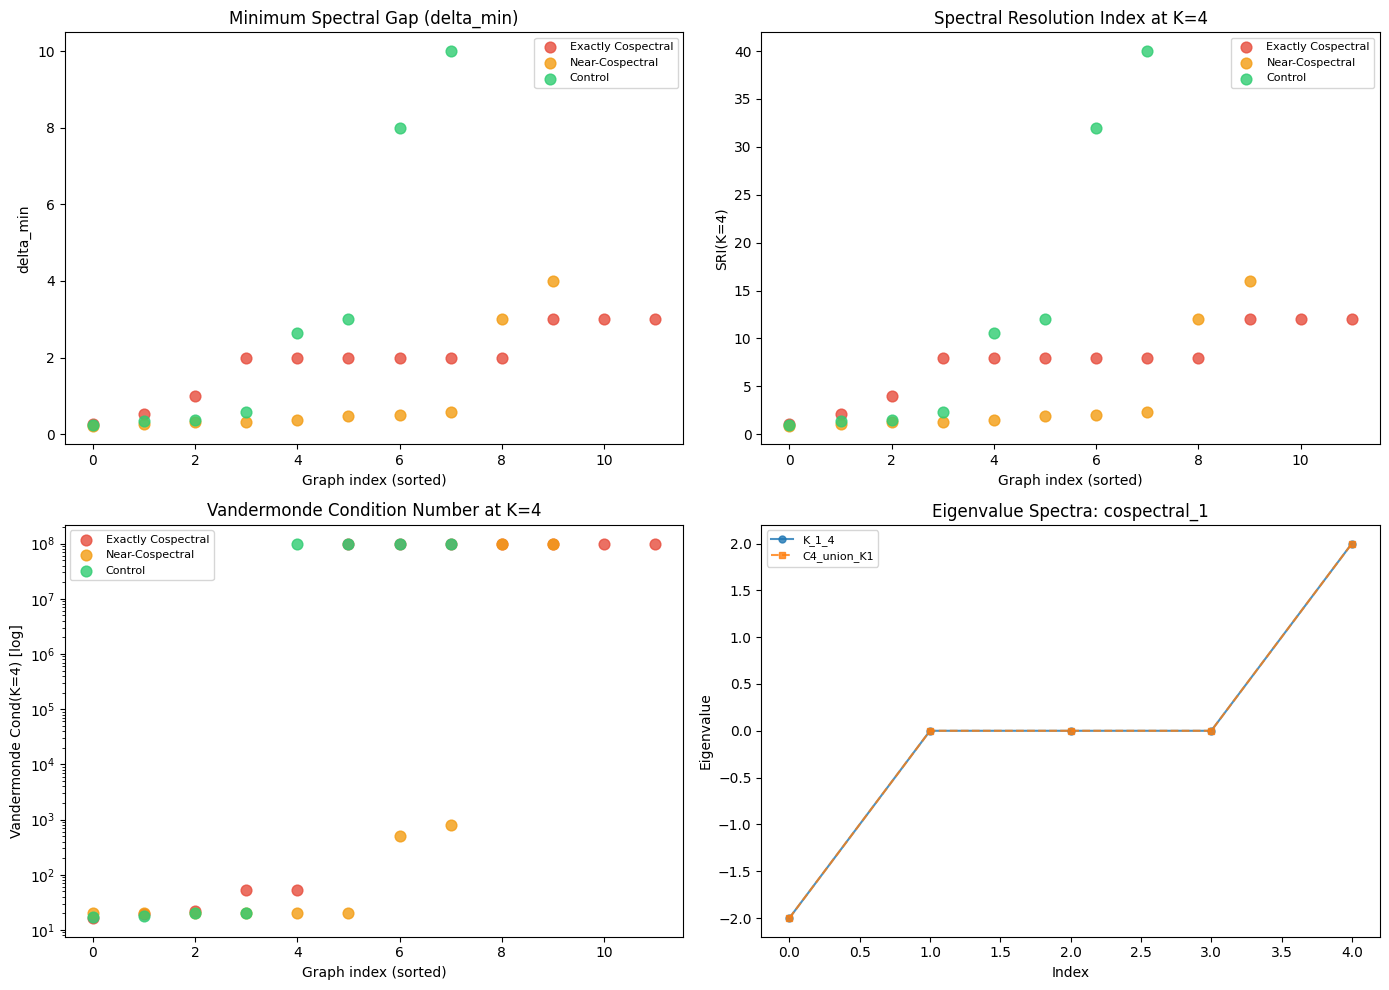

Visualization saved to spectral_analysis.png


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Collect data by category
cat_data = defaultdict(lambda: {"delta_min": [], "sri_k4": [], "vcond_k4": [], "nodes": []})
for g in parsed:
    cat = g["metadata"].get("metadata_pair_category", "unknown")
    cat_data[cat]["delta_min"].append(g["spectral"]["delta_min"])
    cat_data[cat]["sri_k4"].append(g["spectral"]["sri"].get("K=4", 0))
    vc = g["spectral"]["vandermonde_cond"].get("K=4", 0)
    cat_data[cat]["vcond_k4"].append(min(vc, 1e8))  # cap for display
    cat_data[cat]["nodes"].append(g["num_nodes"])

colors = {"exactly_cospectral": "#e74c3c", "near_cospectral": "#f39c12", "control": "#2ecc71"}
cat_labels = {"exactly_cospectral": "Exactly Cospectral", "near_cospectral": "Near-Cospectral", "control": "Control"}

# Plot 1: delta_min distribution
ax = axes[0, 0]
for cat in ["exactly_cospectral", "near_cospectral", "control"]:
    if cat in cat_data:
        vals = cat_data[cat]["delta_min"]
        ax.scatter(range(len(vals)), sorted(vals), label=cat_labels[cat], color=colors[cat], alpha=0.8, s=60)
ax.set_ylabel("delta_min")
ax.set_xlabel("Graph index (sorted)")
ax.set_title("Minimum Spectral Gap (delta_min)")
ax.legend(fontsize=8)

# Plot 2: SRI at K=4
ax = axes[0, 1]
for cat in ["exactly_cospectral", "near_cospectral", "control"]:
    if cat in cat_data:
        vals = cat_data[cat]["sri_k4"]
        ax.scatter(range(len(vals)), sorted(vals), label=cat_labels[cat], color=colors[cat], alpha=0.8, s=60)
ax.set_ylabel("SRI(K=4)")
ax.set_xlabel("Graph index (sorted)")
ax.set_title("Spectral Resolution Index at K=4")
ax.legend(fontsize=8)

# Plot 3: Vandermonde condition number (log scale)
ax = axes[1, 0]
for cat in ["exactly_cospectral", "near_cospectral", "control"]:
    if cat in cat_data:
        vals = [max(v, 1) for v in cat_data[cat]["vcond_k4"]]
        ax.scatter(range(len(vals)), sorted(vals), label=cat_labels[cat], color=colors[cat], alpha=0.8, s=60)
ax.set_yscale("log")
ax.set_ylabel("Vandermonde Cond(K=4) [log]")
ax.set_xlabel("Graph index (sorted)")
ax.set_title("Vandermonde Condition Number at K=4")
ax.legend(fontsize=8)

# Plot 4: Eigenvalue spectra of a cospectral pair
ax = axes[1, 1]
# Find first cospectral pair with 2 graphs
pair_plotted = False
for pid, gs in sorted(pairs.items()):
    if "cospectral" in pid and "near" not in pid and len(gs) >= 2:
        g1, g2 = gs[0], gs[1]
        ax.plot(g1["spectral"]["eigenvalues"], "o-", label=g1.get("graph_name", "G1"), alpha=0.8, markersize=5)
        ax.plot(g2["spectral"]["eigenvalues"], "s--", label=g2.get("graph_name", "G2"), alpha=0.8, markersize=5)
        ax.set_title(f"Eigenvalue Spectra: {pid}")
        ax.set_xlabel("Index")
        ax.set_ylabel("Eigenvalue")
        ax.legend(fontsize=8)
        pair_plotted = True
        break
if not pair_plotted:
    ax.text(0.5, 0.5, "No cospectral pair found", ha="center", va="center", transform=ax.transAxes)

plt.tight_layout()
plt.savefig("spectral_analysis.png", dpi=100, bbox_inches="tight")
plt.show()
print("Visualization saved to spectral_analysis.png")